## Instructions for quantum memory devices

In [1]:
import netsquid as ns
import netsquid.components.instructions as instr
from netsquid.components.qmemory import QuantumMemory

In [3]:
# instructions can be applied ot a quantum memroy by using instruction directly as callable object w qmem as arugment
qmemory = QuantumMemory('ExampleQMem', num_positions=1)
instr.INSTR_INIT(qmemory, positions=[0])
instr.INSTR_H(qmemory, positions=[0])
instr.INSTR_MEASURE_X(qmemory, positions=[0])

[0]

In [8]:
# new instructions can be created using provided base subclasses
from netsquid.qubits import operators as ops
INSTR_XY = instr.IGate("xy_gate", ops.X * ops.Y)

In [12]:
#QuantumProcessor base class adds methods to QuantumMemory for handling instrucitons
# .execute_instructions()

from netsquid.components.qprocessor import QuantumProcessor

qproc = QuantumProcessor("ExmapleQPU", num_positions=3, fallback_to_nonphysical=True)
qproc.execute_instruction(instr.INSTR_INIT, [0,1])
qproc.execute_instruction(instr.INSTR_H, [1])
qproc.execute_instruction(instr.INSTR_CNOT, [1,0])

m1 = qproc.execute_instruction(instr.INSTR_MEASURE, [0])
m2 = qproc.execute_instruction(instr.INSTR_MEASURE, [1])

m1 == m2
ns.sim_time()

0.0

## Physical Instructions

Let us consider an example of how to specify physical instructions for a quantum processor that has the following (toy) characteristics:
- Three qubit memory positions.
- Qubits on any of the memory positions experience depolarisation noise when idle.
- Initialisation of qubits on all of the memory positions takes 3 nanoseconds.
- The single qubit gates Hadamard, X, Z and S can be applied to memory positions 0 and 2 and take 1 nanosecond.
- Applying the CNOT gate takes 4 nanoseconds and can only have memory position 1 as its target.
- All qubits can be measured in the standard (Z) basis, which takes 7 nanoseconds. A measurement of position 1 suffers depolarising noise

In [15]:
from netsquid.components.models.qerrormodels import DepolarNoiseModel
from netsquid.components.qprocessor import PhysicalInstruction

phys_instructions = [
    PhysicalInstruction(instr.INSTR_INIT, duration=3),
    PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True,
                        topology=[(0, 1), (2, 1)]),
    PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(
        instr.INSTR_MEASURE, duration=7, parallel=False,
        quantum_noise_model=DepolarNoiseModel(depolar_rate=0.01, time_independent=True),
        apply_q_noise_after=False, topology=[1]),
    PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=True,
                        topology=[0, 2])
]

noisy_qproc = QuantumProcessor("NoisyQPU", num_positions=3,
                               mem_noise_models=[DepolarNoiseModel(1e7)] * 3,
                               phys_instructions=phys_instructions)

can also specify topology to limti avaialbity of physical instructions to specific memory positions as such: 
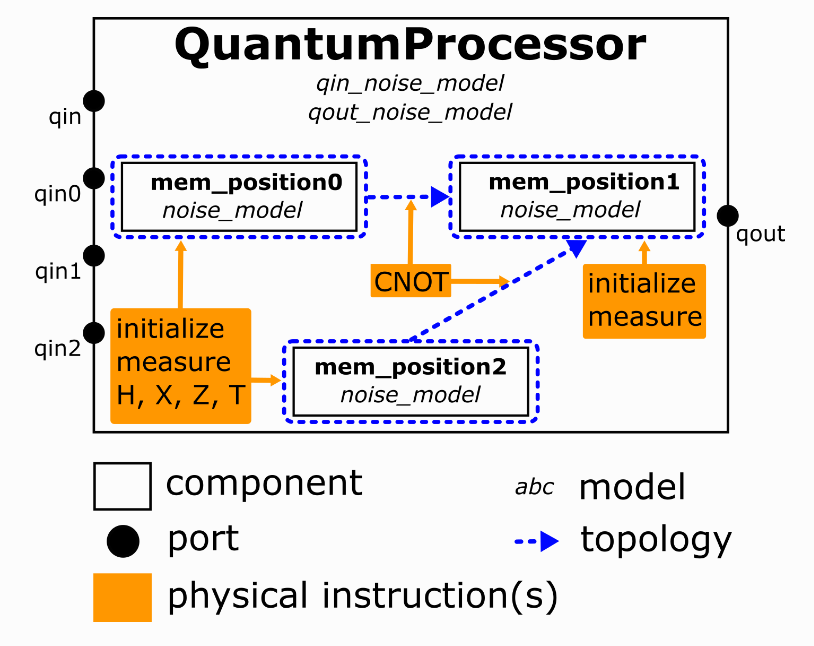
<br> QP, unitl initialized with fallback_to_nonphysical=True will throw error when cant map instruction to be executied to a matching physical instruction

In [16]:
noisy_qproc.execute_instruction(instr.INSTR_Y, [0])

MissingInstructionError: Missing physical instruction for Instruction: y_gate

In [17]:
ns.sim_time()

noisy_qproc.execute_instruction(instr.INSTR_INIT, [0,1])
ns.sim_run()
ns.sim_time()

3.0

if attempt to execute rest of entangling circuit problems will arise bc trying to execute intructions hwiel earlier instructions have not finished yet, so must call ns.sim_run() bw each instruction we can turn to quantum programs 

## Quantum Programs

In [31]:
# treating quantum program as a single sequence of instructions:
from netsquid.components.qprogram import QuantumProgram

prog = QuantumProgram(num_qubits=2)
q1,q2 = prog.get_qubit_indices(2) # get qubit indices we'll be workign with
prog.apply(instr.INSTR_INIT, [q1,q2])
prog.apply(instr.INSTR_H, q1)
prog.apply(instr.INSTR_CNOT, [q1,q2])
prog.apply(instr.INSTR_MEASURE, q1, output_key="m1")
prog.apply(instr.INSTR_MEASURE, q2, output_key="m2")


In [32]:
# must seperate on another line of code
noisy_qproc.reset()
ns.sim_reset()

noisy_qproc.execute_program(prog, qubit_mapping = [2,1])
ns.sim_run()
ns.sim_time()
prog.output["m1"] == prog.output["m2"]
prog.output["m1"], prog.output["m2"]

([1], [1])

In [33]:
# mutliple sequences defined using repeated yield statements calling the .run() method
#during .run(), isntructions store output in lcoal state dictionary called output
# here, meareuemtn resutsl stored in output ["m1"] and output["m2"]
# use control logic to select which instrucitosn are called 

class ControlledQPrograms(QuantumProgram):
    default_num_qubits = 3
    
    def program(self):
        q1,q2,q3 = self.get_qubit_indices(3)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key = "m1")
        yield self.run()
        # depending on outcome on q1 either flip q2 or q3
        if self.output["m1"][0] == 0:
            self.apply(instr.INSTR_X, q2)
        else: 
            self.apply(instr.INSTR_x, q3)
        self.apply(instr.INSTR_MEASURE, q2, output_key="m2")
        self.apply(instr.INSTR_MEASURE, q3, output_key="m3")
        yield self.run(parallel = False)

The parallel parameter in the run() method can be used to control whether the quantum processor attempts to run the sequence in parallel. To do so, both the matching PhysicalInstruction and quantum processor must support this.

# local teleportation example using programs

First, qubit 1 and 2 will need to be entangled. This is done in parallel to creating the state to teleport. A Bell measurement is performed on qubit 0 and 1 once the 3 qubits are ready. The measurement results need to be known before the correction operations can be applied. So the program first needs to run before the correction can take place.

In [34]:
noisy_qproc.reset()
ns.sim_reset()
ns.set_qstate_formalism(ns.QFormalism.DM)

class TeleportationProgram(QuantumProgram):
    default_num_qubits = 3

    def program(self):
        q0, q1, q2 = self.get_qubit_indices(3)
        # Entangle q1 and q2:
        self.apply(instr.INSTR_INIT, [q0, q1, q2])
        self.apply(instr.INSTR_H, q2)
        self.apply(instr.INSTR_CNOT, [q2, q1])
        # Set q0 to the desired state to be teleported:
        self.apply(instr.INSTR_H, q0)
        self.apply(instr.INSTR_S, q0)
        # Bell measurement:
        self.apply(instr.INSTR_CNOT, [q0, q1])
        self.apply(instr.INSTR_H, q0)
        self.apply(instr.INSTR_MEASURE, q0, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q1, output_key="M2")
        yield self.run()
        # Do corrections:
        if self.output["M2"][0] == 1:
            self.apply(instr.INSTR_X, q2)
        if self.output["M1"][0] == 1:
            self.apply(instr.INSTR_Z, q2)
        yield self.run()


noisy_qproc.execute_program(TeleportationProgram())
ns.sim_run()
qubit = noisy_qproc.pop(2)
fidelity = ns.qubits.fidelity(
    qubit, ns.qubits.outerprod((ns.S*ns.H*ns.s0).arr), squared=True)
print(f"{fidelity:.3f}")

0.922


## additional features

In [36]:
# parametr physical can be used to indicate whether quantum processor should match isntruction to a PhysicalInstruciton or execute it instnatnly and iwhtout noise, i.e. non-physical

class CheatingQProgram(QuantumProgram):
    default_num_qubits = 2
    
    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_X, q1)
        self.apply(instr.INSTR_SIGNAL, physical = False)
        self.apply(instr.INSTR_Z, q1, physical = False)
        self.apply(instr.INSTR_CNOT, [q1,q1])
        self.apply(instr.INSTR_MEASURE, q1, output_key = "m1", physical = False)
        self.apply(instr.INSTR_MEASURE, q2, output_key = "m2", physical = False)
        yield self.run()
        


In [38]:
# a program can load in another program using .load() method
# loaded programs share output directory

class LoadingQProgram(QuantumProgram):
    default_num_qubits = 2
    
    def program(self):
        # run a regular sequence
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_X, q1)
        yield self.run()
        # load and run another program
        yield from self.load(CheatingQProgram)

In [40]:
# program concatenation
prog3 = prog1 + prog2

# program repetition using multipliccation operator
prog2 = prog1 * 5

NameError: name 'prog1' is not defined